In [1]:
import numpy as np
import numdifftools as nd
from scipy.interpolate import splrep, splev
from scipy import interpolate, optimize, stats
import matplotlib.pyplot as plt

https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev

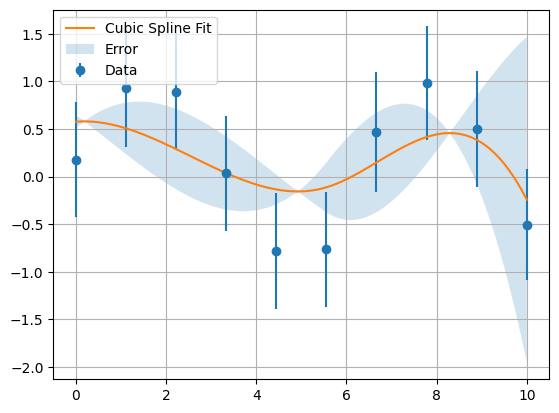

In [2]:
# Generate random data with errors
np.random.seed(0)
x = np.linspace(0, 10, 10)
y = np.sin(x) + np.random.normal(0, 0.1, len(x))
y_err = np.random.normal(0.1, 0.02, len(x)) + 0.5

# Fit a weighted cubic spline using splrep
tck = splrep(x, y, w=1. / y_err, k=3)

# Interpolate values using splev
x_interp = np.linspace(0, 10, 100)
y_interp = splev(x_interp, tck)

# Calculate the fitted values at the data points (for residuals)
y_fit = splev(x, tck)

# Calculate residuals
residuals = y - y_fit

# Calculate chi-squared and degrees of freedom
chi2 = np.sum((residuals / y_err) ** 2)
dof = len(x) - len(tck[1]) // 3 - 1

# Covariance matrix for weighted least squares
cov_matrix = np.diag(y_err ** 2) * chi2 / dof

# Compute Jacobians at interpolated points
jacobian = np.array([splev(xi, tck, der=1) for xi in x_interp])

# Extract the diagonal elements of the covariance matrix (variances)
variances = np.diag(cov_matrix)

# Convert variances to column vector for broadcasting
variances_column = variances[:, np.newaxis]

# Propagate errors through the squared Jacobian and sum up
jacobian_squared = jacobian ** 2
weighted_jacobian = jacobian_squared * variances_column
sum_weighted_jacobian = np.sum(weighted_jacobian, axis=0)

# Calculate the final interpolated errors
y_interp_err = np.sqrt(sum_weighted_jacobian)

# Plot the results
fig, axe = plt.subplots()
axe.errorbar(x, y, yerr=y_err, fmt='o', label='Data')
axe.plot(x_interp, y_interp, label='Cubic Spline Fit')
axe.fill_between(x_interp, y_interp - y_interp_err, y_interp + y_interp_err, alpha=0.2, label='Error')
axe.legend()
axe.grid()

In [3]:
def model(x, a, b, c):
    return a * np.sin(b * x) + c

In [4]:
np.random.seed(0)
m = 10
x = np.linspace(0, 10, m)
s = 0.5 * np.ones(x.size)
n = s * np.random.normal(size=x.size)
p = (1., 1., 0.)
y = model(x, *p)
yn = y + n

In [5]:
xlin = np.linspace(x.min(), x.max(), 200)
ylin = model(xlin, *p)

In [6]:
tck = interpolate.splrep(x, yn, w=1/s, k=3)
spline = interpolate.BSpline(*tck)
yspl = spline(xlin)

In [14]:
popt, pcov = optimize.curve_fit(model, x, yn, sigma=s, absolute_sigma=True)
yhat = model(xlin, *popt)

In [9]:
def variance(model, x, p, Cp):
    
    def proxy(q):
        return model(x, *q)
    
    def projection(J):
        return J @ Cp @ J.T
    
    Jp = nd.Gradient(proxy)(p)
    Cy = np.apply_along_axis(projection, 1, Jp)
    
    return Cy

In [10]:
Cy = variance(model, xlin, popt, pcov)

In [11]:
alpha = 0.01
z = stats.norm.ppf(1 - alpha / 2.)
Cy = variance(model, xlin, popt, pcov)
sy = np.sqrt(Cy)
ci = z * sy

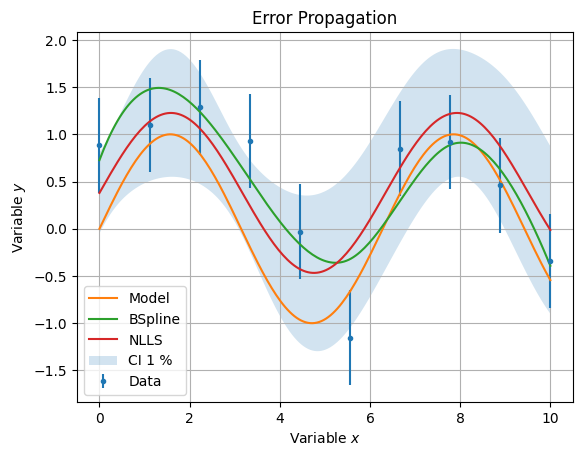

In [12]:
fig, axe = plt.subplots()
axe.errorbar(x, yn, yerr=s, linestyle="none", marker=".", label="Data")
axe.plot(xlin, ylin, label="Model")
axe.plot(xlin, yspl, label="BSpline")
axe.plot(xlin, yhat, label="NLLS")
axe.fill_between(xlin, yhat - ci, yhat + ci, alpha=0.2, label="CI 1 %")
axe.set_title("Error Propagation")
axe.set_xlabel("Variable $x$")
axe.set_ylabel("Variable $y$")
axe.legend()
axe.grid()